In [21]:
from math import pi, sqrt
import numpy as np
import matplotlib.pyplot as plt
import os

# Openmc

In [25]:
import openmc
from openmc import deplete, stats
openmc.__version__

'0.15.0'

# Материалы

In [11]:
# Materials
fuel_mat = openmc.Material(name='mat1')
fuel_mat.add_element('U', 1, enrichment=5)
fuel_mat.add_element('O', 2)
fuel_mat.set_density('g/cm3', 8.3)
fuel_mat.volume = pi*10**2*100
water_mat = openmc.Material(name='mat2')
water_mat.add_element('H', 2)
water_mat.add_element('O', 1)
water_mat.set_density('g/cm3', 1)

materials = openmc.Materials([fuel_mat, water_mat, ])

# Геометрия

In [12]:
fuel_surf = openmc.ZCylinder(r=10)
water_surf = openmc.model.HexagonalPrism(edge_length=20, orientation='x', boundary_type='reflective')

top_surf = openmc.ZPlane(z0=100 / 2)
bottom_surf = openmc.ZPlane(z0=-100 / 2)


top_surf.boundary_type = 'vacuum'
bottom_surf.boundary_type = 'vacuum'


# 1. tvel in water
fuel_cell = openmc.Cell(fill=fuel_mat, region=-fuel_surf & +bottom_surf & -top_surf)
water_cell = openmc.Cell(fill=water_mat, region=+fuel_surf & -water_surf & +bottom_surf & -top_surf)

universe = openmc.Universe(cells=[fuel_cell, water_cell])

geometry = openmc.Geometry(universe)

# Картинки

## Matplotlib

<Axes: >

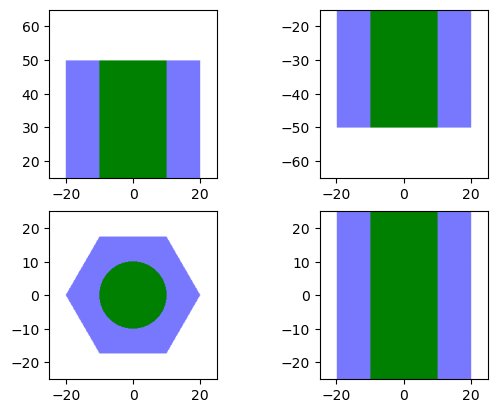

In [17]:
colors = {water_mat: (120, 120, 255),  fuel_mat: 'green'}
color_data = dict(color_by='material', colors=colors)
width = (50,50)

fig, ax = plt.subplots(2, 2)

universe.plot(width=width, pixels=(250, 250), basis='xz', **color_data, origin=(0, 0, 100 / 2 - 10), axes=ax[0][0])
universe.plot(width=width, pixels=(250, 250), basis='xz', **color_data, origin=(0, 0, 0), axes=ax[1][1])
universe.plot(width=width, pixels=(250, 250), basis='xz', **color_data, origin=(0, 0, -100 / 2 + 10), axes=ax[0][1])
universe.plot(width=width, pixels=(250, 250), basis='xy', **color_data, origin=(0, 0, 0), axes=ax[1][0])

## OpenMC

In [18]:
plots = [openmc.Plot(), openmc.Plot(), openmc.Plot(), openmc.Plot(), ]
for i in range(4):
    # plots[i].id=(i+1)*111
    plots[i].width = width
    plots[i].pixels = (500, 500)
    plots[i].basis = 'xz'
    plots[i].color_by = 'material'
    plots[i].colors = colors
plots[0].origin = (0, 0, 3500 / 2 -10)
plots[2].origin = (0, 0, -3500/2+10)
plots[-1].basis = 'xy'


plots = openmc.Plots(plots)

# Настройки

In [ ]:
setting = openmc.Settings()
setting.batches = 100
setting.inactive = 10
setting.particles = 5000

uniform_dist = openmc.stats.Box([-10, -10, -3500 / 2], [10, 10, 3500 / 2], only_fissionable=True)
setting.source = openmc.source.Source(space=uniform_dist)
setting.run_mode = 'fixed source'
# Tallies
flux_tally = openmc.Tally(name='flux')
flux_tally.scores = ['flux']

U_tally = openmc.Tally(name='fuel')
U_tally.scores = ['fission', 'total', 'absorption', 'elastic', 'scatter', 'decay-rate']
U_tally.nuclides = ['U235', 'U238']

tallies = openmc.Tallies([U_tally, flux_tally])
# tally.filters = [cell_filter,energy_filter]

/home/nikita/.conda/envs/science/lib/python3.11/site-packages/openmc/stats/multivariate.py:829: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "
/home/nikita/.conda/envs/science/lib/python3.11/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


# Экспорт конфигов

In [23]:
os.makedirs('xmls', exist_ok=True)
materials.export_to_xml('xmls/materials.xml')
geometry.export_to_xml('xmls/geometry.xml')
setting.export_to_xml('xmls/settings.xml')
tallies.export_to_xml('xmls/tallies.xml')
plots.export_to_xml('xmls/plots.xml')
print("xml export finished")

xml export finished


# Запуск

In [26]:
model = openmc.Model(geometry=geometry, materials=materials, tallies=tallies, plots=plots, settings=setting)
openmc.plot_geometry(path_input='xmls/')
# openmc.run(output=False,path_input='xmls/')
# Deplition
operator = deplete.CoupledOperator(model=model)
power = 1e6
time_steps = [1]
integrator = deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='s')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

DataError: Cross sections were not specified in Model.materials and openmc.config['cross_sections'] is not set.